In [90]:
import requests
from bs4 import BeautifulSoup
from lxml import html
import pandas as pd
import pickle
import re
import os
import urllib.request


url = 'https://syllabus.naist.jp/subjects/preview_list'
res = requests.get(url)
soup = BeautifulSoup(res.text, 'html.parser')

lxml = html.fromstring(str(soup))

title = []
url = []

#授業名(title)とシラバスの授業ページへのurl(url)
title.append(lxml.xpath('//td[@class="w20pr"]/a/text()'))
url.append(lxml.xpath('//td[@class="w20pr"]/a/@href'))

head = 'https://syllabus.naist.jp/'

#'教育目的'と'授業概要'があるのでそれぞれpurpose, conceptとして集める
purpose = []
concept = []
for i in range(len(title[0])):
    print(head + url[0][i])
    res2 = requests.get(head + url[0][i])
    soup2 = BeautifulSoup(res2.text, 'html.parser')
    lxml2 = html.fromstring(str(soup2))



    purpose.append(lxml2.xpath('//th[text()="教育目的／授業目標"]/following-sibling::td[1]/text()')[0])
    concept.append(lxml2.xpath('//th[text()="授業概要／指導方針"]/following-sibling::td[1]/text()')[0])
    
df = pd.DataFrame({'授業名': title[0], 'シラバスURL':url[0], '教育目的': purpose, '授業概要': concept})

df['uni'] = df['教育目的'] + df['授業概要']
#今回は日本語シラバスのみを対象にしたいので、英語で書かれているなどのシラバスは削除
df.drop(df.index[[0,4,10,11,12,13,14,16,67,110]], inplace=True)
df = df.reset_index(drop=True)

https://syllabus.naist.jp//subjects/preview_detail/401
https://syllabus.naist.jp//subjects/preview_detail/402
https://syllabus.naist.jp//subjects/preview_detail/403
https://syllabus.naist.jp//subjects/preview_detail/404
https://syllabus.naist.jp//subjects/preview_detail/600
https://syllabus.naist.jp//subjects/preview_detail/405
https://syllabus.naist.jp//subjects/preview_detail/406
https://syllabus.naist.jp//subjects/preview_detail/407
https://syllabus.naist.jp//subjects/preview_detail/408
https://syllabus.naist.jp//subjects/preview_detail/409
https://syllabus.naist.jp//subjects/preview_detail/410
https://syllabus.naist.jp//subjects/preview_detail/411
https://syllabus.naist.jp//subjects/preview_detail/412
https://syllabus.naist.jp//subjects/preview_detail/413
https://syllabus.naist.jp//subjects/preview_detail/414
https://syllabus.naist.jp//subjects/preview_detail/415
https://syllabus.naist.jp//subjects/preview_detail/416
https://syllabus.naist.jp//subjects/preview_detail/598
https://sy

In [78]:

with open('data.pickle', 'rb') as f:
    df = pickle.load(f)


In [79]:

from janome.tokenizer import Tokenizer
t = Tokenizer()

def tokenizer(text):
    text = re.sub('\d+', '', text)
    return [tok for tok in t.tokenize(text, wakati=True)]

    
df['wakati'] = df['uni'].apply(tokenizer)

In [81]:

def download_stopwords(path):
    url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
    if os.path.exists(path):
        print('File already exists.')
    else:
        print('Downloading...')
        # Download the file from `url` and save it locally under `file_name`:
        urllib.request.urlretrieve(url, path)

def create_stopwords(file_path):
    stop_words = []
    for w in open(path, "r"):
        w = w.replace('\n','')
        if len(w) > 0:
          stop_words.append(w)
    return stop_words    

path = "stop_words.txt"
download_stopwords(path)
stop_words = create_stopwords(path)

#option:ストップワード以外の不要な文字
option = ['(', ')', '（', '）', ',', '、', '。', '／', '/', '：', ':', '[', ']', '・', '.', '（']
stop_words = stop_words + option

#数字、アルファベットを削除

#分かち書きしたテキストに対してストップワードを削除
def stopwords(wakati):
    return [t for t in wakati if t not in stop_words]


#前処理
df['wakati'] = df['wakati'].apply(stopwords)



File already exists.


In [90]:
#分かち書きしたシラバスからDoc2Vecで分散表現を得る
#Kmeansでクラスタリングするときに次元数が多いと距離関係を有効に使えなさそうなので、PCAで次元削減する。
from gensim.models.doc2vec import Doc2Vec
from sklearn.decomposition import PCA
model = Doc2Vec.load("jawiki.doc2vec.dbow300d.model")

df['vec'] = df['wakati'].apply(model.infer_vector)
pca = PCA(n_components=2)

data_pca= pca.fit_transform(df['vec'].values.tolist())



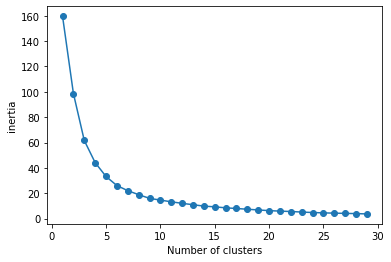

In [112]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []

for i  in range(1,30):               
    km = KMeans(n_clusters=i,
                init='k-means++', 
                n_init=10,
                max_iter=300,
                random_state=2020)
    km.fit(data_pca)
    distortions.append(km.inertia_)

plt.plot(range(1,30),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.show()


In [ ]:
n_clusters = 5
kmeans_model = KMeans(n_clusters=n_clusters, verbose=1, random_state=2020, n_jobs=-1, max_iter = 500)

kmeans_model.fit(data_pca)
label = kmeans_model.labels_
df['kmeans'] = label

In [95]:
#wordcloudで使う名詞リストの準備

def extract_noun(text):
    nouns = []
    tokened = stopwords(t.tokenize(text))
    for token in t.tokenize(text):
        part_of_speech = token.part_of_speech.split(',')[0]
        if part_of_speech == u'名詞':
            word = token.surface
            nouns.append(word)
    return nouns

df['noun'] = df['uni'].apply(extract_noun)
df['noun'] = df['noun'].apply(stopwords)

In [111]:
from wordcloud import WordCloud



def text_for_wordcloud(data, idx):

    text = []
    Series = data[data['kmeans'] == idx]['noun']
    for col in Series:
        text += col
    
    text = ' '.join(text)
    
    fpath = "~/Library/Fonts/Arial Unicode.ttf"
    wc = WordCloud(width=480, height=320, font_path = fpath)
    wc.generate(text)
    wc.to_file("wordcloud%s.png" % idx)
    


for i in range(5):
    text_for_wordcloud(df, i)
